# Assignment #3 20200045 Kimgeonwoo
- Fill in the blank cells below.
- Submit this notebook file via KLMS
- Due date : __2021.11.16(Wed) 9am__
    * after due date, submission is still allowed after due date.
        * with delay penalty of 20% / day
        * actual score = original score before penalty * (100% - delay penalty)
        * submission will be closed after 4 days of due date

## Regression and Classification
- __Task 1__. Continuation on House price prediction
    * Ordinal Variable encoding and missing value imputation
    * Regression with advanced decision trees
        * Bagging, Random Forest, XGBoost, LightGBM
    * Heterogeneous ensemble
    * Neural Network (optional)
    * Submit the best model result to kaggle
- __Task 2__. Binary classification on home credit default risk
    * Data preprocessing
    * Classification with advanced models
    * Submit the best model result to kaggle

### Task 1. Continuation on House price prediction
- predicting house price with advanced regression models

#### Preliminary : Recap of datareprocessing in Assignment #2 
- read data, take log-price as label, combine train+exam for preprocessing $\to$ X_combined0 
- remove columns with too many missing values (more than 20%) $\to$ X_combined1
- separate columns : cardinal(numerical), categorical, and ordinal columns 
- imputation $\to$ X_combined2
    * numeric columns : strategy = mean
    * categorical columns : strategy = most_frequent
- add interaction column : 'GrLivArea' * 'OverallQual'  $\to$ X_combined2
- handling ordinal variables : task 1-1
- encoding categorical variables
- split combined data into $D_{model}$ and $D_{exam}$

In [42]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore')

In [59]:
# read train data +exam data, then combine them for preprocessing
from google.colab import drive
drive.mount('/content/drive')

XY_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/train.csv', index_col=0)

Y_all = np.log(XY_all['SalePrice'])
X_all = XY_all.drop('SalePrice', axis=1)
X_exam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/test.csv', index_col=0)

X_combined0 = pd.concat([X_all, X_exam], axis=0)
print (X_combined0.info())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 79 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   Alley          198 non-null    object 
 6   LotShape       2919 non-null   object 
 7   LandContour    2919 non-null   object 
 8   Utilities      2917 non-null   object 
 9   LotConfig      2919 non-null   object 
 10  LandSlope      2919 non-null   object 
 11  Neighborhood   2919 non-null   object 
 12  Condition1     2919 non-null   object 
 13  Condition2     2919 non-null   object 
 14  BldgType       2919 non-null   object 
 15  HouseStyle 

In [60]:
# remove columns with missing values more than 20%
X_null = X_combined0.isnull().sum(axis=0)
max_na = X_combined0.shape[0] * 0.2
col = [c for c in X_combined0.columns if X_null[c] <= max_na]
X_combined1 = X_combined0[col]
print (X_combined1.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 74 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2919 non-null   int64  
 1   MSZoning       2915 non-null   object 
 2   LotFrontage    2433 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   Street         2919 non-null   object 
 5   LotShape       2919 non-null   object 
 6   LandContour    2919 non-null   object 
 7   Utilities      2917 non-null   object 
 8   LotConfig      2919 non-null   object 
 9   LandSlope      2919 non-null   object 
 10  Neighborhood   2919 non-null   object 
 11  Condition1     2919 non-null   object 
 12  Condition2     2919 non-null   object 
 13  BldgType       2919 non-null   object 
 14  HouseStyle     2919 non-null   object 
 15  OverallQual    2919 non-null   int64  
 16  OverallCond    2919 non-null   int64  
 17  YearBuilt      2919 non-null   int64  
 18  YearRemo

#### Ordinal columns
- Some of string columns are actually ordinal variables. For example, 
    ExterQual: Evaluates the quality of the material on the exterior 
           Ex	Excellent
           Gd	Good
           TA	Average/Typical
           Fa	Fair
           Po	Poor
- Treating ordinal variable as categorical may introduce too many dummy variables
    * harmful for generalization
- There are 10 such ordinal columns.
```python
grade_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
                'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
```

In [61]:
# some string columns are categorical, but some are ordinal
num_cols = X_combined1.select_dtypes(include=np.number).columns.tolist()
str_cols = X_combined1.select_dtypes(include='object').columns.tolist()
grade_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
            'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
cat_cols = str_cols.copy()
ord_cols = []
for c in grade_cols:
    if c in cat_cols:
        cat_cols.remove(c)
        ord_cols.append(c)
        
print ("Cardinal columns = ", len(num_cols))
print ("Categorical columns = ", len(cat_cols))
print ("Ordinal columns = ", ord_cols)

Cardinal columns =  36
Categorical columns =  30
Ordinal columns =  ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']


In [62]:
# imputation for cardinal (numeric) columns and categorical columns
from sklearn.impute import SimpleImputer

# imputation for cardinal (numeric) columns
num_imputer = SimpleImputer(strategy='mean')
X_combined2 = X_combined1.copy()
X_combined2[num_cols] = num_imputer.fit_transform(X_combined1[num_cols])

# imputation for categirical columns 
# note that ordinal columns are not imputed yet
str_imputer = SimpleImputer(strategy='most_frequent')
X_combined2[cat_cols] = str_imputer.fit_transform(X_combined1[cat_cols])

# add an interaction column
X_combined2['GrLivArea * OverallQual'] = X_combined2['GrLivArea'] * X_combined2['OverallQual']
print (X_combined2.info())
X_combined2

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 75 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MSSubClass               2919 non-null   float64
 1   MSZoning                 2919 non-null   object 
 2   LotFrontage              2919 non-null   float64
 3   LotArea                  2919 non-null   float64
 4   Street                   2919 non-null   object 
 5   LotShape                 2919 non-null   object 
 6   LandContour              2919 non-null   object 
 7   Utilities                2919 non-null   object 
 8   LotConfig                2919 non-null   object 
 9   LandSlope                2919 non-null   object 
 10  Neighborhood             2919 non-null   object 
 11  Condition1               2919 non-null   object 
 12  Condition2               2919 non-null   object 
 13  BldgType                 2919 non-null   object 
 14  HouseStyle              

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,GrLivArea * OverallQual
Id,,,,,,,,,,,,,,,,,,,,,
1,60.0,RL,65.0,8450.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,2.0,2008.0,WD,Normal,11970.0
2,20.0,RL,80.0,9600.0,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,0.0,0.0,0.0,5.0,2007.0,WD,Normal,7572.0
3,60.0,RL,68.0,11250.0,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,9.0,2008.0,WD,Normal,12502.0
4,70.0,RL,60.0,9550.0,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272.0,0.0,0.0,0.0,0.0,2.0,2006.0,WD,Abnorml,12019.0
5,60.0,RL,84.0,14260.0,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0.0,0.0,0.0,0.0,0.0,12.0,2008.0,WD,Normal,17584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160.0,RM,21.0,1936.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,6.0,2006.0,WD,Normal,4368.0
2916,160.0,RM,21.0,1894.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,4.0,2006.0,WD,Abnorml,4368.0
2917,20.0,RL,160.0,20000.0,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0.0,0.0,0.0,0.0,0.0,9.0,2006.0,WD,Abnorml,6120.0


#### Task 1-1. Data preprocessing : encoding and imputation of ordinal variables
- fill in the following cell
    * mapping ordinal column (grade) to integer(0~5), as follows:
        - 'Ex' → 5
        - 'Gd' → 4
        - 'TA' → 3
        - 'Fa' → 2
        - 'Po' → 1
        - 'NA' → 0
        - np.nan → np.nan
    - Hint : uses DataFrame.map function
        ```python
        ord2int_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:np.nan}                         
        data['ExterQual'].map(dictionary)
        ```
    * imputing missing values in ordinal columns
        - strategy = 'mean'
    * result : stored in X_combined3

In [63]:
# Task 1-1. Ordinal variable integer encoding and missing value imputation

ord2int_map = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':0, np.nan:np.nan}

X_combined3 = X_combined2.copy()


for c in ord_cols:
    X_combined3[c] = X_combined2[c].map(ord2int_map)

X_combined3[ord_cols] = num_imputer.fit_transform(X_combined3[ord_cols])


#### Split data and test with ridge regression
- replace categorical variable with dummy variables
- split combined data
- test data with ridge regression

In [64]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# extract exam data from pre-processed combined data
def split_train_exam(X_combined, n):
    X_task = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_task, X_exam

# function to compute R^2 & RMSE and print them
# prefix : string to be printed at the front of a line
def model_perf(model, X, Y, prefix=''):
    Yhat = model.predict(X)
    r2 = r2_score(Y, Yhat)
    rmse = mean_squared_error(Y, Yhat, squared=False)
    print (f'{prefix} R^2 score = {r2:.3f}, RMSE = {rmse:.4f}')

def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=0)
    model.fit(X_trn, Y_trn)
    print (prefix)
    model_perf(model, X_trn, Y_trn, '  Training  ')
    model_perf(model, X_val, Y_val, '  Validation')
    kfold = KFold(n_splits=5, shuffle=True, random_state=0)
    s = cross_val_score(model, X_all, Y_all, cv=kfold)
    print (f'  Cross val. R^2 score mean = {s.mean():.3f}, std = {s.std():.3f}')

In [66]:
# let's test with ridge regression
# for this, we need to convert categorical var. to dummy var.
X_combined4 = pd.get_dummies(X_combined3)

# extract exam data from pre-processed combined data

X_task1, X_exam1 = split_train_exam(X_combined4, X_all.shape[0])

ridge = Ridge()
model_fit_perf(ridge, X_task1, Y_all, "Ridge")

Ridge
  Training   R^2 score = 0.946, RMSE = 0.0936
  Validation R^2 score = 0.767, RMSE = 0.1876
  Cross val. R^2 score mean = 0.868, std = 0.053


#### Task 1-2. Advanced decision trees
- Based on above data `X_task1`, `Y_all`, try the following tree models
    * BaggingRegressor
        - use n_estimators=50
    * RandomForestRegressor
        - use n_estimators=50
    * XGBRegressor
        - use max_depth=5
    * LGBMRegressor
- You may try different parameters to optimize each model    
- expected output (this is a sample output.  you may see different numbers.)
        Bagging 
          Training   R^2 score = 0.983, RMSE = 0.0527
          Validation R^2 score = 0.869, RMSE = 0.1408
          Cross val. R^2 score mean = 0.874, std = 0.018
        Random Forest 
          Training   R^2 score = 0.983, RMSE = 0.0526
          Validation R^2 score = 0.870, RMSE = 0.1403
          Cross val. R^2 score mean = 0.875, std = 0.019
        XGBoost 
          Training   R^2 score = 0.998, RMSE = 0.0184
          Validation R^2 score = 0.864, RMSE = 0.1435
          Cross val. R^2 score mean = 0.877, std = 0.019
        LightGBM 
          Training   R^2 score = 0.988, RMSE = 0.0442
          Validation R^2 score = 0.876, RMSE = 0.1371
          Cross val. R^2 score mean = 0.890, std = 0.020

In [67]:
## Task 1-2 : Regression with advanced tree models on house price data

!pip install xgboost
!pip install lightgbm
%matplotlib inline
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
import xgboost
import lightgbm

bdt = BaggingRegressor(n_estimators=50)
model_fit_perf(bdt, X_task1, Y_all, "Bagging")
rf = RandomForestRegressor(n_estimators=50)
model_fit_perf(rf, X_task1, Y_all, "Random Forest")
xgb = xgboost.XGBRegressor(objective='reg:squarederror',max_depth=5)
model_fit_perf(xgb, X_task1, Y_all, "XGBoost")
lgbm = lightgbm.LGBMRegressor()
model_fit_perf(lgbm, X_task1, Y_all, "LightGBM")

Bagging
  Training   R^2 score = 0.983, RMSE = 0.0525
  Validation R^2 score = 0.873, RMSE = 0.1386
  Cross val. R^2 score mean = 0.877, std = 0.017
Random Forest
  Training   R^2 score = 0.982, RMSE = 0.0539
  Validation R^2 score = 0.870, RMSE = 0.1403
  Cross val. R^2 score mean = 0.877, std = 0.017
XGBoost
  Training   R^2 score = 0.982, RMSE = 0.0541
  Validation R^2 score = 0.881, RMSE = 0.1341
  Cross val. R^2 score mean = 0.898, std = 0.015
LightGBM
  Training   R^2 score = 0.988, RMSE = 0.0442
  Validation R^2 score = 0.876, RMSE = 0.1371
  Cross val. R^2 score mean = 0.890, std = 0.020


#### Task 1-3. Heterogeneous ensembles
- Compose henerogeneous ensembles
    * estimators (base models) : Ridge, Bagging, Random forest, XGBoost, LightGBM
    * VotingRegressor
    * StackingRegressor
        - use Ridge or LightGBM for final_estimator
- You may try different parameters to optimize each model
- expected output (this is a sample output.  you may see different numbers.)
        Voting(mean) Ensemble 
          Training   R^2 score = 0.987, RMSE = 0.0464
          Validation R^2 score = 0.877, RMSE = 0.1363
          Cross val. R^2 score mean = 0.897, std = 0.022
        Stacking Ensemble 
          Training   R^2 score = 0.959, RMSE = 0.0818
          Validation R^2 score = 0.869, RMSE = 0.1407
          Cross val. R^2 score mean = 0.889, std = 0.020

In [69]:
## Task 1-3 : VotingRegressor and StackingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor

models = [('Ridge', ridge),('Bagging', bdt), ('Random Forest', rf), ('XGBoost', xgb), ('LightGBM', lgbm)]

voting = VotingRegressor(estimators=models)
model_fit_perf(voting, X_task1, Y_all, "Voting(mean) Ensemble")

stacking = StackingRegressor(estimators=models)
model_fit_perf(stacking, X_task1, Y_all, "Stacking Ensemble")



Voting(mean) Ensemble
  Training   R^2 score = 0.983, RMSE = 0.0521
  Validation R^2 score = 0.881, RMSE = 0.1341
  Cross val. R^2 score mean = 0.899, std = 0.022
Stacking Ensemble
  Training   R^2 score = 0.976, RMSE = 0.0618
  Validation R^2 score = 0.866, RMSE = 0.1422
  Cross val. R^2 score mean = 0.900, std = 0.026


#### Task 1-4. Submit your best result to Kaggle
- Predict price for exam data using the trained model
    * note that your prediction will give log-price
    * so, take `np.exp()` to get price
- Read 'sample_submission.csv' file
- Replace 'SalePrice' column with your prediction price
- Write to 'mysub.csv' file
- Submit your result to kaggle
    * Leaderboard tab $\to$ `Submit predictions` button
    * step 1 : drag and drop your 'mysub.csv' file
    * step 2 : describe your submission $\to$ write something here like "my second homework result" 
    * click `make submission` button $\to$ you will get your exam score
    * ![image.png](attachment:a1a85b2c-8216-4295-8bef-1f39b847a1f0.png)
    * by clicking "jump to your position on the leaderboard", you can check your ranking
- Capture your ranking and attach it in the next cell

In [70]:
# Task 1-4. fill-in this code cell 
best_model = voting
Y_exam = best_model.predict(X_exam1)

Y_exam = np.exp(Y_exam)

submisson = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/sample_submission.csv',index_col='Id')

submisson['SalePrice'] = Y_exam

submisson.to_csv('/content/drive/MyDrive/Colab Notebooks/house-prices-advanced-regression-techniques/mysub.csv',sep = ',', na_rep= 'Nan')


- Paste screen capture of your leaderboard ranking here for task 1-5
- replace the sample shown here
![image.png](attachment:deabef24-f4d2-4923-9bf2-6569cc1036c7.png)

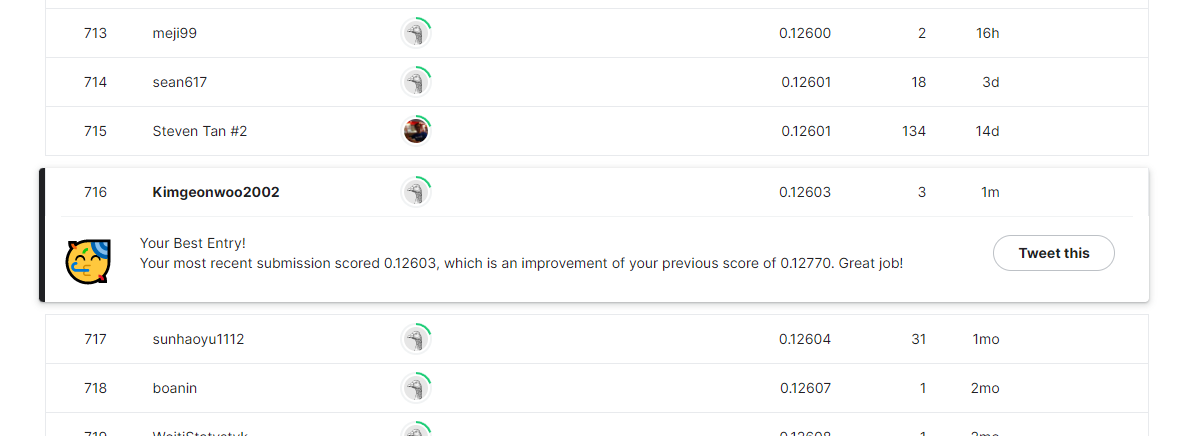

### Task 2. Binary classification

1.  Competition : Home Credit Default Risk
    * https://www.kaggle.com/c/home-credit-default-risk
    * This kaggle competition is to predict whether a customer default or not. (binary classification)
1. Data download 
    * In the `data` section of the competition, there are 9 data files which are connected.
    * For simplicity, we will use only the main data file.
        * `application_train.csv` : dataset for building model
        * `application_test.csv`: exam dataset
    * application_train.csv : data available for __model developing__
        - 122 columns x 307511 customer's records with label (TARGET)
            * first column : row id 
            * second column : label ('TARGET')
                - 0: no default,  1: default
            * 120 features
    * application_test.csv : __exam data__
        - 121 columns, about 48744 customer's records without label (TARGET)
        - you are supposed to fill in label (TARGET) column with default probability predicted by your prediction model
        - and submit it to kaggle to see your exam score and ranking in the leaderboard
    * Features : total 120 features available
        - Numeric
            * Cardinal: AMT_INCOME_TOTAL etc.
        - Categorical (Nominal): NAME_CONTRACT_TYPE etc.
        - Refer to `HomeCredit_columns_description.xlsx` in details
        - Note that there are many __missing values__ 
1. Evaluation measure
    - evaluation measure used in this competition : __AUROC__ (=AUCROC)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings(action='ignore')

# extract exam data from pre-processed combined data
def split_train_exam(X_combined, n):
    X_task = X_combined.iloc[:n,:]
    X_exam = X_combined.iloc[n:,:]
    return X_task, X_exam

#### Task 2-1. Data preprocessing
- Data preprocessing as in task 1
    - read data, combine train+exam for preprocessing
        * 120 col * 356255 rows
    - remove columns with too many missing values (more than 20%)
        * 70 col remain
    - separate columns : cardinal(numerical), categorical
        - in this task, you may assume that there is no ordinal columns
            * if you think some columns are ordinal, you may treat assign numeric values.
        - cardinal (numeric) : 59
        - categorical (nominal) : 11
    - imputation $\to$ X_combined2
        * numeric columns : strategy = mean
        * categorical columns : strategy = most_frequent
            * SimpleImputer(strategy='most_frequent') is SO slow
            * Instead, consider using pd.Series.fillna(value=v) function
                * X_combined[col] is a pd.Series
                * v = X_combined[col].mode()[0] gives the most frequent value in the column
                * X_combined[col].fillna(value=v)
    - encoding categorical variables
        * pd.get_dummies
    - split combined data into X_task2 and X_exam2
        * use split_train_exam()

In [2]:
# Task 2-1 : preprocessing

from google.colab import drive
drive.mount('/content/drive')

XY_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/home-credit-default-risk/application_train.csv', index_col=0)

Y_all = XY_all['TARGET']
X_all = XY_all.drop('TARGET', axis=1)
X_exam = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/home-credit-default-risk/application_test.csv', index_col=0)

X_combined0 = pd.concat([X_all, X_exam], axis=0)
#print (X_combined0.info())


X_null = X_combined0.isnull().sum(axis=0)
max_na = X_combined0.shape[0] * 0.2
col = [c for c in X_combined0.columns if X_null[c] <= max_na]
X_combined1 = X_combined0[col]
print (X_combined1.info())


Mounted at /content/drive
<class 'pandas.core.frame.DataFrame'>
Int64Index: 356255 entries, 100002 to 456250
Data columns (total 70 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   NAME_CONTRACT_TYPE           356255 non-null  object 
 1   CODE_GENDER                  356255 non-null  object 
 2   FLAG_OWN_CAR                 356255 non-null  object 
 3   FLAG_OWN_REALTY              356255 non-null  object 
 4   CNT_CHILDREN                 356255 non-null  int64  
 5   AMT_INCOME_TOTAL             356255 non-null  float64
 6   AMT_CREDIT                   356255 non-null  float64
 7   AMT_ANNUITY                  356219 non-null  float64
 8   AMT_GOODS_PRICE              355977 non-null  float64
 9   NAME_TYPE_SUITE              354052 non-null  object 
 10  NAME_INCOME_TYPE             356255 non-null  object 
 11  NAME_EDUCATION_TYPE          356255 non-null  object 
 12  NAME_FAMILY_STATUS         

In [3]:
str_cols = X_combined1.select_dtypes(include='object').columns.tolist() #categorical (nominal) : 11
num_cols = X_combined1.select_dtypes(include=np.number).columns.tolist() #cardinal (numeric) : 59


from sklearn.impute import SimpleImputer
# imputation for cardinal (numeric) columns
num_imputer = SimpleImputer(strategy='mean')
X_combined2 = X_combined1.copy()
X_combined2[num_cols] = num_imputer.fit_transform(X_combined1[num_cols])

for c in str_cols:
    v = X_combined1[c].mode()[0]
    X_combined2[col].fillna(value=v)

#X_combined2.info()
X_combined3 = pd.get_dummies(X_combined2)


In [4]:
X_task2, X_exam2 = split_train_exam(X_combined3, X_all.shape[0])

#### Task 2-2. Classification with advanced models
- Find the best classifier for `X_task2`, `Y_all`
    - use model_fit_perf() function to fit and test the model
- You should try at least three of the following models
    * BaggingClassifier
        * this may take too much time for fitting
    * RandomForestClassifier
        * need to determine n_estimators.  try 50.
    * XGBClassifier
    * LGBMClassifier
        * LightGBM cannot handle column names with some special characters
        * So, you have to rename columns. You may simply replaced names by numbers
    * VotingClassfier
        * soft or hard voting
    * StackingClassifier
        * need to specify final_estimator
            * consider using LogisticRegression, LightGBM, or SVM (Support Vector Machine) 
- Hyper-parameter tuning
    * After selecting most promissing model, tune hyper-parameters for the model
        * look documents for the model 
        * you may try different parameters to optimize the model
        * or GridSearchCV or RandomizedSearchCV
- Expected output (this is a sample output. you may see different numbers.)
    Bagging 
      Training   AUROC score = 1.000
      Validation AUROC score = 0.686
    Random Forest 
      Training   AUROC score = 0.928
      Validation AUROC score = 0.728
    XGBoost 
      Training   AUROC score = 0.808
      Validation AUROC score = 0.745
    LightGBM 
      Training   AUROC score = 0.790
      Validation AUROC score = 0.749

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
import xgboost
import lightgbm

# function to compute R^2 & RMSE and print them
# prefix : string to be printed at the front of a line
def model_perf(model, X, Y, prefix=''):
    p_hat = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(Y, p_hat)
    print (f'{prefix} AUROC score = {auc:.3f}')

# note : cross validation is not included because of computation time
def model_fit_perf(model, X_all, Y_all, prefix=''):
    X_trn, X_val, Y_trn, Y_val = train_test_split(X_all, Y_all, test_size=0.2, random_state=4)
    model.fit(X_trn, Y_trn)
    print (prefix)
    model_perf(model, X_trn, Y_trn, '  Training  ')
    model_perf(model, X_val, Y_val, '  Validation')

In [6]:
# Task 2-2-1 : model 1
rf = RandomForestClassifier(n_estimators=50)
model_fit_perf(rf, X_task2, Y_all, "Random Forest")



Random Forest
  Training   AUROC score = 1.000
  Validation AUROC score = 0.701


In [7]:
# Task 2-2-2 : model 2
bag = BaggingClassifier(n_estimators=50)
model_fit_perf(bag, X_task2, Y_all, "Bagging")


Bagging
  Training   AUROC score = 1.000
  Validation AUROC score = 0.687


In [8]:
# Task 2-2-3 : model 3
xgb = xgboost.XGBClassifier(verbosity=0) 
model_fit_perf(xgb, X_task2, Y_all, "XGBoost")


XGBoost
  Training   AUROC score = 0.753
  Validation AUROC score = 0.743


In [33]:
# Task 2-2-4 : model 4
lgbm = lightgbm.LGBMClassifier(verbose=-1)
model_fit_perf(lgbm, X_task2, Y_all, "LightGBM")


LightGBM
  Training   AUROC score = 0.791
  Validation AUROC score = 0.749


In [16]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

models = [('RandomForest', rf),('Bagging', bag), ('XGBoost', xgb), ('LightGBM', lgbm)]

In [35]:
voting = VotingClassifier(estimators=models, voting='soft')
model_fit_perf(voting, X_task2, Y_all, "Voting(mean) Ensemble")

Voting(mean) Ensemble
  Training   AUROC score = 1.000
  Validation AUROC score = 0.737


In [34]:
parameters = {'num_leaves':[20,40,60,80,100],'max_depth':[-1,5,10,20],'n_estimators':[50,100,150,200]}

from sklearn.model_selection import RandomizedSearchCV

random_search = RandomizedSearchCV(lgbm,parameters,scoring='neg_mean_absolute_error')
random_search.fit(X_task2, Y_all)

print(random_search.best_params_)
best_model =  lightgbm.LGBMClassifier(num_leaves= random_search.best_params_['num_leaves'],max_depth= random_search.best_params_['max_depth'],n_estimators= random_search.best_params_['n_estimators'],verbose=-1)
model_fit_perf(best_model, X_task2, Y_all, "Hyper-parameter tuning")

{'num_leaves': 40, 'n_estimators': 100, 'max_depth': 10}
Hyper-parameter tuning
  Training   AUROC score = 0.800
  Validation AUROC score = 0.749


#### Task 2-3. Submit your best result to Kaggle
- Download and read 'sample_submission.csv' file
- Replace 'TARGET' column with your predicted default probability (0~1)
    * use the best model you trained.
    * p = model.predcit_proba(X_exam2)
    * p[:,1] is the default probability (probability for class 1)
- Write to 'mysub2.csv' file
- Submit your result to kaggle
    * Leaderboard tab $\to$ `Late Submission` button
    * step 1 : drag and drop your 'mysub2.csv' file
    * step 2 : describe your submission $\to$ write something here like "my 3rd homework result" 
    * click `make submission` button $\to$ you will get your exam score
- Capture your submission score and attach it in the next cell

In [41]:
# Task 2-3. fill-in this code cell 

submisson = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/home-credit-default-risk/sample_submission.csv',index_col='SK_ID_CURR')

p = best_model.predict(X_exam2)

submisson['TARGET'] = p

submisson.to_csv('/content/drive/MyDrive/Colab Notebooks/home-credit-default-risk/mysub2.csv',sep = ',', na_rep= 'Nan')

- Paste screen capture of your submission score at Kaggle
- replace the sample shown here
![image.png](attachment:c1c3f455-fb38-47ca-878a-e706c30fa4dd.png)
- If you can see your ranking on the leaderboard, capture and paste here.
    - It seems that you cannot see your ranking in this competition.

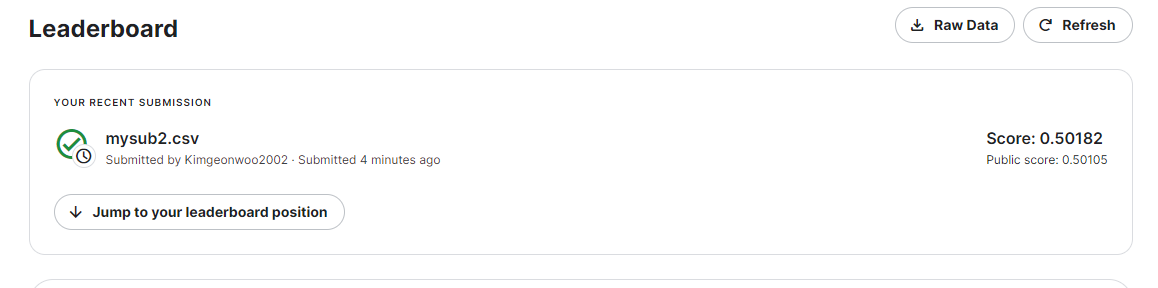